# Vehicle Detection

## Histogram of Oriented Gradients (HOG) feature extraction
Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images.

In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
# imports
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import time

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label

%matplotlib inline

print("initialized imports")

initialized imports


In [3]:
# Utility functions

#Display two images side by side and save the output.
def display2(title1, img1, title2, img2, output_file, cmaps=None):
    if len(img1.shape) > 2:
        img1 = img1[:, :, ::-1]
    if len(img2.shape) > 2:
        img2 = img2[:, :, ::-1]
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    if cmaps is None:
        ax1.imshow(img1)
    else:
        ax1.imshow(img1, cmap=cmaps[0])
    ax1.set_title(title1, fontsize=15)
    if cmaps is None:
        ax2.imshow(img2)
    else:
        ax2.imshow(img2, cmap=cmaps[1])
    ax2.set_title(title2, fontsize=15)
    plt.savefig(output_file, bbox_inches='tight')

#Display one image side by side and save the output.
def display1(title1, img1, output_file, cmap=None):
    if len(img1.shape) > 2:
        img1 = img1[:, :, ::-1]
    f, ax1 = plt.subplots(1, 1, figsize=(5,5))
    if cmap is None:
        ax1.imshow(img1)
    else:
        ax1.imshow(img1, cmap=cmap)
    ax1.imshow(img1)
    ax1.set_title(title1, fontsize=15)
    plt.savefig(output_file, bbox_inches='tight')
    
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img
    
print("initialized utilities")

initialized utilities


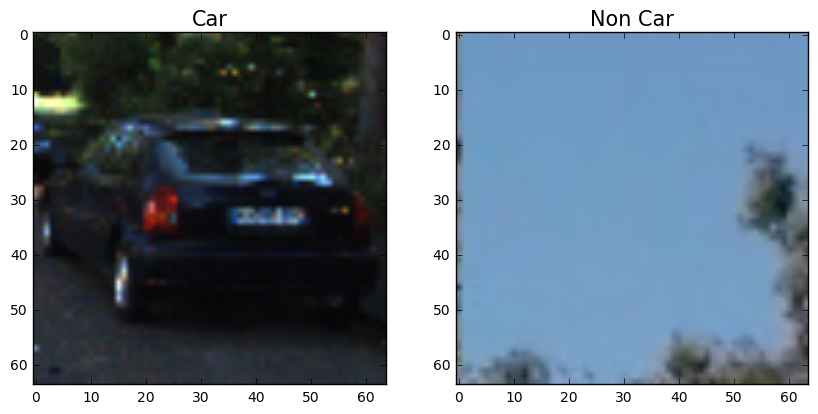

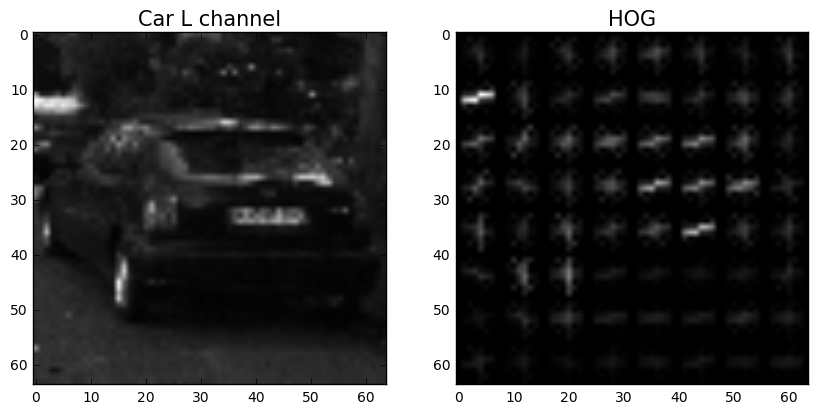

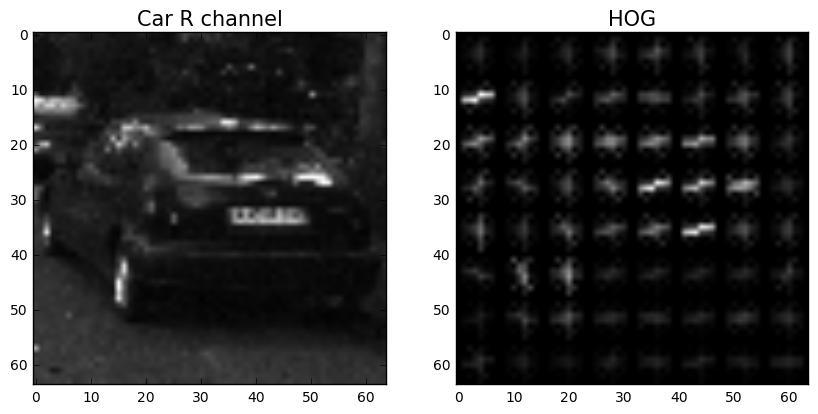

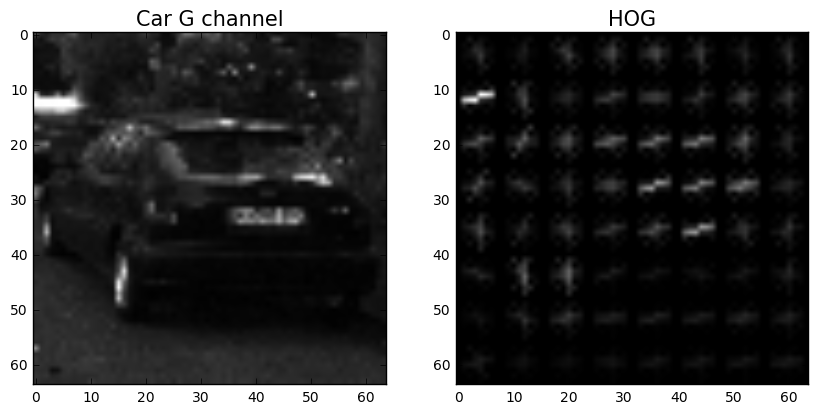

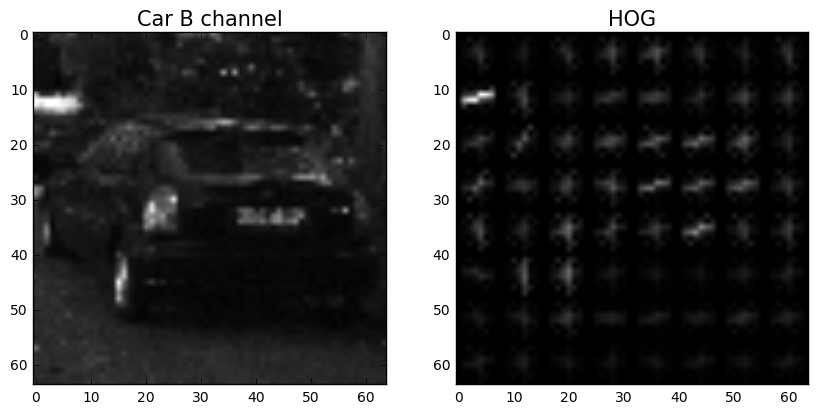

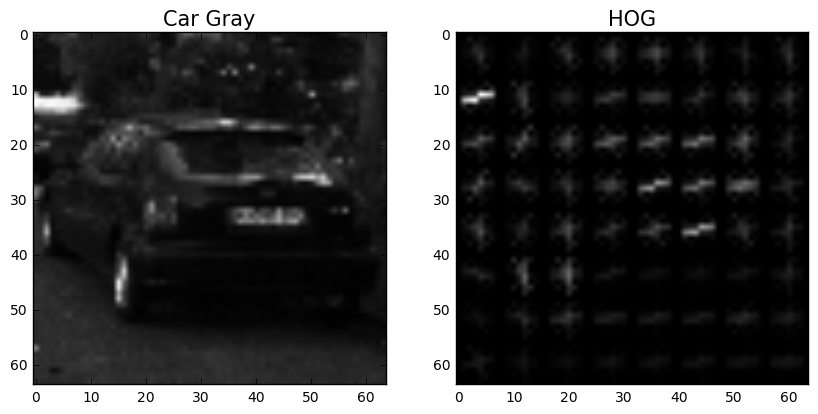

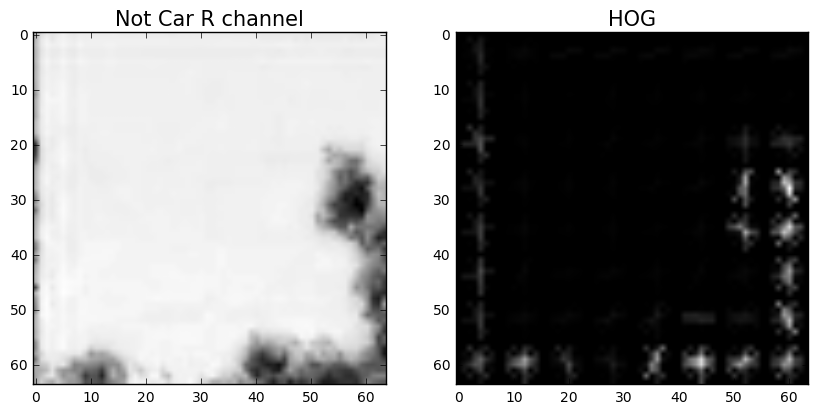

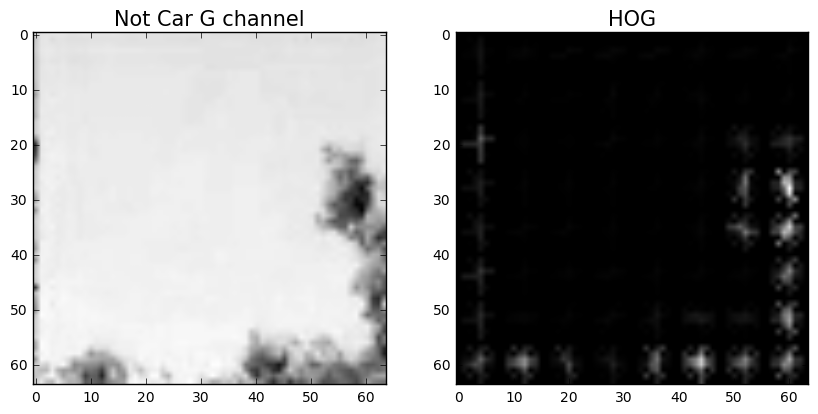

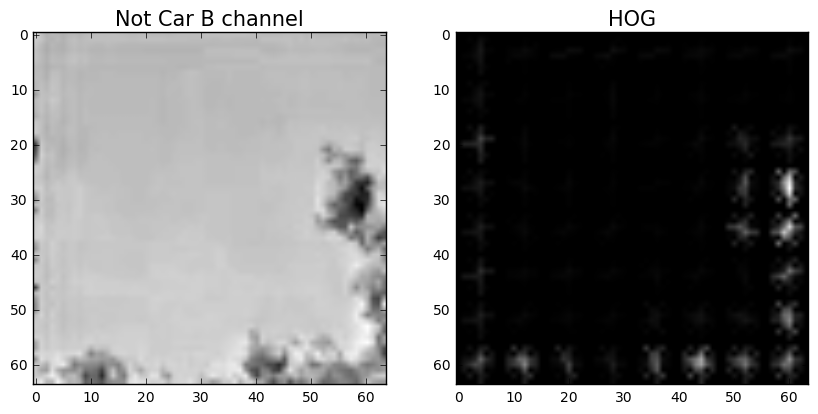

In [24]:
# HOG Extraction on a sample image.

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        return hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=feature_vec, transform_sqrt=True)
    else:      
        # Use skimage.hog() to get features only
        return hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=False, feature_vector=feature_vec, transform_sqrt=True)

# Car / Not a Car 101.png
car = cv2.imread("vehicles/KITTI_extracted/5000.png")
non_car = cv2.imread("non-vehicles/Extras/extra1.png")
display2("Car", car, "Non Car", non_car, "car_non_car.jpg")

# HOG extraction, tuning parameters
pix_per_cell = 8
cell_per_block = 2
orient = 9

# Experiments
car_hls = cv2.cvtColor(car, cv2.COLOR_BGR2HLS)
features, hog_image = get_hog_features(car_hls[:, :, 1], orient, pix_per_cell, cell_per_block, vis=True)
display2("Car L channel", car_hls[:, :, 1], "HOG", hog_image, "hog_features_l.jpg", ("gray", "gray"))

features, hog_image = get_hog_features(car[:, :, 0], orient, pix_per_cell, cell_per_block, vis=True)
display2("Car R channel", car[:, :, 0], "HOG", hog_image, "hog_features_r.jpg", ("gray", "gray"))

features, hog_image = get_hog_features(car[:, :, 1], orient, pix_per_cell, cell_per_block, vis=True)
display2("Car G channel", car[:, :, 1], "HOG", hog_image, "hog_features_g.jpg", ("gray", "gray"))

features, hog_image = get_hog_features(car[:, :, 2], orient, pix_per_cell, cell_per_block, vis=True)
display2("Car B channel", car[:, :, 2], "HOG", hog_image, "hog_features_b.jpg", ("gray", "gray"))

car_gray = cv2.cvtColor(car, cv2.COLOR_BGR2GRAY)
features, hog_image = get_hog_features(car_gray, orient, pix_per_cell, cell_per_block, vis=True)
display2("Car Gray", car_gray, "HOG", hog_image, "hog_features_gray.jpg", ("gray", "gray"))

features, hog_image = get_hog_features(non_car[:, :, 0], orient, pix_per_cell, cell_per_block, vis=True)
display2("Not Car R channel", non_car[:, :, 0], "HOG", hog_image, "n_hog_features_r.jpg", ("gray", "gray"))

features, hog_image = get_hog_features(non_car[:, :, 1], orient, pix_per_cell, cell_per_block, vis=True)
display2("Not Car G channel", non_car[:, :, 1], "HOG", hog_image, "n_hog_features_g.jpg", ("gray", "gray"))

features, hog_image = get_hog_features(non_car[:, :, 2], orient, pix_per_cell, cell_per_block, vis=True)
display2("Not Car B channel", non_car[:, :, 2], "HOG", hog_image, "n_hog_features_b.jpg", ("gray", "gray"))

In [5]:
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def extract_features(img):
    # resize step.
    if img.shape[0] < 64:
        img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)
    elif img.shape[0] > 64:
        img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_LINEAR)
    #img_hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    f1 = get_hog_features(img[:, :, 0], orient, pix_per_cell, cell_per_block)
    f2 = get_hog_features(img[:, :, 1], orient, pix_per_cell, cell_per_block)
    f3 = get_hog_features(img[:, :, 2], orient, pix_per_cell, cell_per_block)
    f0 = bin_spatial(img)
    f4 = color_hist(img)
    return np.hstack((f0, f1, f2, f3, f4))
    
print("intialized function to extract features")

intialized function to extract features


In [6]:
# HOG Extraction on training dataset.

# Load training data
car_images = glob.glob("vehicles/KITTI_extracted/*.png")
non_car_images = glob.glob("non-vehicles/Extras/extra*.png")

x_car = np.zeros([len(car_images), (3072 + 1764*3 + 32*3)], dtype=np.float32)
x_non_car = np.zeros([len(non_car_images), (3072 + 1764*3 + 32*3)], dtype=np.float32)
for i, car_file in enumerate(car_images):
    img = cv2.imread(car_file)
    x_car[i] = extract_features(img)

for i, car_file in enumerate(non_car_images):
    img = cv2.imread(car_file)
    x_non_car[i] = extract_features(img)

x = np.vstack((x_car, x_non_car)).astype(np.float32)

y_car = np.ones(len(car_images), dtype=np.float32)
y_non_car = np.zeros(len(non_car_images), dtype=np.float32)
y = np.concatenate([y_car, y_non_car])

# Fit a per-column scaler
x_scaler = StandardScaler().fit(x)
# Apply the scaler to X
x = x_scaler.transform(x)

#TODO: Add HOG features from other channels as well
#TODO: Add the data from the GTI dataset

print(y.shape)
print(x.shape)
print("Loaded training data!!")

(11310,)
(11310, 8460)
Loaded training data!!


## Training a classifier using HOG features
Train a classifier Linear SVM classifier.

In [7]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=rand_state)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(x_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(x_test, y_test), 4))
print('Train Accuracy of SVC = ', round(svc.score(x_train, y_train), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(x_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

(9048, 8460)
(2262, 8460)
(9048,)
(2262,)
16.0 Seconds to train SVC...
Test Accuracy of SVC =  0.996
Train Accuracy of SVC =  1.0
My SVC predicts:  [ 1.  1.  0.  1.  1.  1.  1.  1.  1.  1.]
For these 10 labels:  [ 1.  1.  0.  1.  1.  1.  1.  1.  1.  1.]
0.00167 Seconds to predict 10 labels with SVC


In [8]:
# Test classifier on test images
car = cv2.imread("/Users/nalapati/Desktop/1.png")
x = extract_features(car)
print(svc.predict(x_scaler.transform(x)))

#car = mpimg.imread("vehicles/KITTI_extracted/1.png")
car = cv2.imread("non-vehicles/Extras/extra1.png")
x = extract_features(car)
print(svc.predict(x_scaler.transform([x])))

[ 0.]
[ 0.]


## Sliding window search
Run a sliding window of different sizes with overlap over an image and run the classifier over the window to find sliding windows with a vehicle in it.

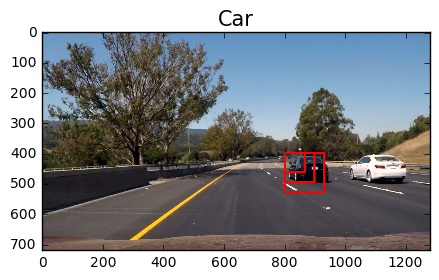

In [22]:
# Testing bounding boxes manually

# Bounding box analysis
car = cv2.imread("test_images/test6.jpg")
result = draw_boxes(car, [
        ((800,400),(864,464)),
        ((800,400),(896,496)),
        ((800,400),(928,528))
    ])

display1("Car", result, "test_bb.jpg")

In [10]:
# retrieve sliding windows.
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
        # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

print("initialized sliding window retriever")

initialized sliding window retriever


56 32x32 windows
78 48x48 windows
64 64x64 windows
42 96x96 windows


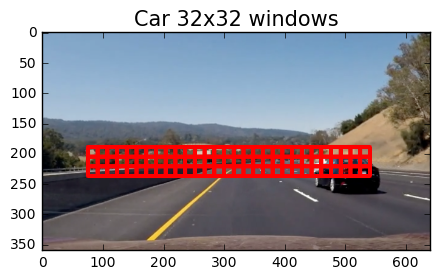

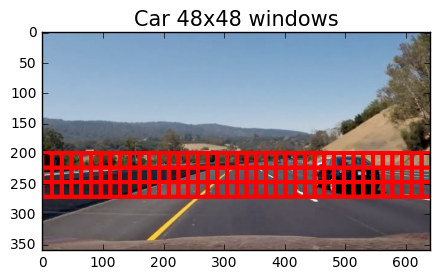

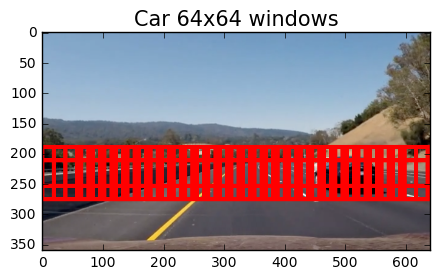

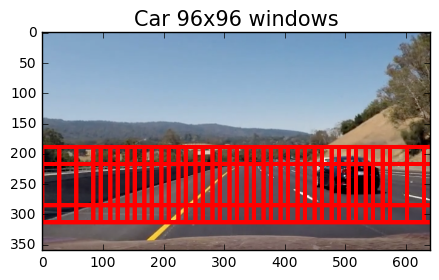

In [11]:
# Test sliding window generator for desired ranges.
car = cv2.imread("test_images/test4.jpg")
car = cv2.resize(car, (640, 360))

windows = slide_window(car, x_start_stop=[75, 550], y_start_stop=[190, 250], xy_window=(32, 32), xy_overlap=(0.5, 0.5))
print("%d 32x32 windows" % len(windows))
result = draw_boxes(car, windows)
display1("Car 32x32 windows", result, "test_32_32.jpg")

windows = slide_window(car, y_start_stop=[200, 275], xy_window=(48, 48), xy_overlap=(0.65, 0.5))
print("%d 48x48 windows" % len(windows))
result = draw_boxes(car, windows)
display1("Car 48x48 windows", result, "test_48_48.jpg")

windows = slide_window(car, y_start_stop=[190, 275], xy_window=(64, 64), xy_overlap=(0.7, 0.65))
print("%d 64x64 windows" % len(windows))
result = draw_boxes(car, windows)
display1("Car 64x64 windows", result, "test_64_64.jpg")

windows = slide_window(car, y_start_stop=[190, 300], xy_window=(96, 96), xy_overlap=(0.7, 0.7)) # 220
print("%d 96x96 windows" % len(windows))
result = draw_boxes(car, windows)
display1("Car 96x96 windows", result, "test_96_96.jpg")

In [12]:
# Apply predictions on windows, return windows with a car.
def get_windows_with_car(img, classifier, x_scaler):
    windows = (
        slide_window(car, x_start_stop=[75, 550], y_start_stop=[190, 250], xy_window=(32, 32), xy_overlap=(0.5, 0.5))
        + slide_window(car, x_start_stop=[25, 625], y_start_stop=[200, 275], xy_window=(48, 48), xy_overlap=(0.65, 0.5))
        + slide_window(car, x_start_stop=[25, 625], y_start_stop=[190, 275], xy_window=(64, 64), xy_overlap=(0.7, 0.65))
        + slide_window(car, x_start_stop=[25, 625], y_start_stop=[190, 300], xy_window=(96, 96), xy_overlap=(0.7, 0.7))
    )
    windows_with_car = []
    for window in windows:
        features = x_scaler.transform(extract_features(img[window[0][1]:window[1][1], window[0][0]:window[1][0], :]))
        if classifier.predict([features])[0] > 0.0:
            windows_with_car.append(window)
    return windows_with_car
    
print("initialized function to return windows with car from input image")

initialized function to return windows with car from input image


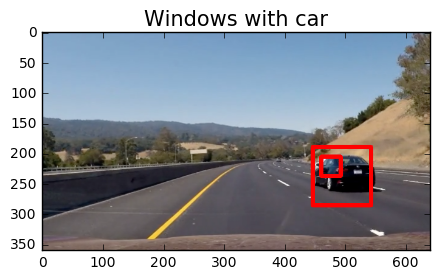

In [13]:
car = cv2.imread("test_images/test6.jpg")
car = cv2.resize(car, (640, 360))
windows_with_car = get_windows_with_car(car, svc, x_scaler)
result = draw_boxes(car, windows_with_car)
display1("Windows with car", result, "test_windows_with_car_result.jpg")

## Heatmap of detected windows and final bounding box
Generate a heatmap out of the bounding boxes in the image. Hottest regions in the image subject to a threshold are the final candidates for a vehicle in an image.

In [14]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

print("initialized heatmap functions")

initialized heatmap functions


2 cars found


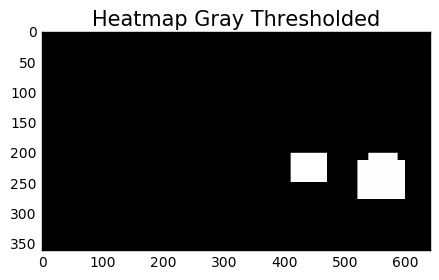

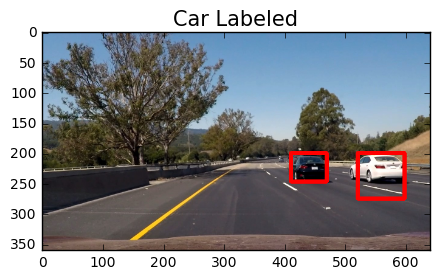

In [15]:
car = cv2.imread("test_images/test6.jpg")
car = cv2.resize(car, (640, 360))

windows_with_car = get_windows_with_car(car, svc, x_scaler)
result = draw_boxes(car, windows_with_car)
heatmap = np.zeros_like(car).astype(np.uint8)
add_heat(heatmap, windows_with_car)
apply_threshold(heatmap, 1)

labels = label(heatmap)
print(labels[1], 'cars found')
display1("Heatmap Gray Thresholded", labels[0], "heatmap_gray_thresholded.jpg", cmap='gray')

car_labeled = draw_labeled_bboxes(car, labels)
display1("Car Labeled", car_labeled, "car_labeled.jpg")

## Video pipeline
Run the above pipeline over every image frame to detect vehicles in each frame.

In [16]:
previous_bboxes = []
img_copy = np.zeros([360, 640, 3], dtype=np.uint8)

previous_labels = None
i = 0

def process_frame(img):
    global i
    global img_copy
    global previous_bboxes
    global previous_labels
    # process frames at 10fps
    img_small = cv2.resize(img, (640, 360))
    if i % 2 == 0:
        img_copy[:, :, :] = img_small[:, :, :]
        img_copy = img_copy[:, :, ::-1]

        windows_with_car = get_windows_with_car(img_copy, svc, x_scaler)
        previous_bboxes.append(windows_with_car)
        if len(previous_bboxes) >= 10:
            previous_bboxes.pop(0)
        windows = []
        for bboxes in previous_bboxes:
            windows = windows + bboxes
        heatmap = np.zeros_like(img).astype(np.uint8)
        add_heat(heatmap, windows)
        apply_threshold(heatmap, 8)
        labels = label(heatmap)
        previous_labels = labels
    else:
        labels = previous_labels
    i = i+1
    car_labeled = draw_labeled_bboxes(img_small, labels)
    return car_labeled

print("initialized frame processor")

initialized frame processor


In [17]:
test_video_output = 'test_video_output.mp4'
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(process_frame)
%time white_clip.write_videofile(test_video_output, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|█████████▋| 38/39 [00:16<00:00,  2.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

CPU times: user 16.8 s, sys: 169 ms, total: 17 s
Wall time: 17.1 s


In [18]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(test_video_output))

In [19]:
project_video_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_frame)
%time white_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [09:07<00:00,  2.30it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 9min 4s, sys: 5.27 s, total: 9min 9s
Wall time: 9min 7s


In [21]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(project_video_output))